# Imports

## Libraries

In [106]:
import warnings
warnings.filterwarnings('ignore')
import shapely
import geopandas as gpd
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import mapclassify as mc
from functions import *
import pysal
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Data

In [2]:
# for all of the charts, a user defined scale is used in multi-city plots, otherwise, equal-interval

charts to make:
- region popularity for each city 
- culinary regions overall
- culinary region for each city
- total region popularity coupled with remittance data 

In [3]:
rest_df = pd.read_csv("../my_saved_data/final_correct_restaurants_and_regions.csv", index_col=0)

In [4]:
with open("../my_saved_data/demonym_dictionary.pickle", "rb+") as f:
    demonym_dict = pickle.load(f)

In [5]:
cul_reg_for_all = pd.read_csv("../my_saved_data/culinary_region_pct_overal.csv", index_col=0)
pct_df = pd.read_csv("../my_saved_data/new_corrected_pct_df.csv", index_col=0)
city_w_cul_reg_pct = pd.read_csv("../my_saved_data/city_w_culinary_region_pct.csv", index_col=0)

In [6]:
mex_gdf = gpd.read_file("../data/MEX_adm1.shp")

In [7]:
remit_df = pd.read_excel("../data/remittances_2020.xlsx", header=7)

In [8]:
mex_pop = pd.read_csv("../data/mex_population_by_state.csv")

# Engineering Data

## Geodataframe

In [9]:
regions_for_gdf = [unidecode.unidecode(x.title()) for x in mex_gdf['NAME_1']]
mex_gdf['Region'] = [x.title() for x in regions_for_gdf]
mex_gdf['Region'].replace(region_replacement_dictionary, inplace=True)
mex_gdf.drop(columns = ['ID_0', 'ID_1', 'ISO', 'NAME_0', 'HASC_1', 'CC_1', 'VALIDFR_1', 'VALIDTO_1', 'REMARKS_1',
       'TYPE_1', 'ENGTYPE_1', 'NL_NAME_1', 'VARNAME_1', 'NAME_1', 'Shape_Leng', 'Shape_Area'], inplace=True)

## Remittances

In [10]:
remit_df.columns = ['X', "State", "Oct-Dec 2019", "Jan-Mar 2020", "Y"]
remit_df.drop(columns = ['X', "Oct-Dec 2019", 'Y'], inplace=True)
remit_df.drop([0, 1, 2, 35, 36, 37], inplace=True)

In [11]:
new_state_names = []
for state in remit_df['State']:
    for idx, x in enumerate(state):
        if x.isalpha() == True:
            new_name = unidecode.unidecode(state[idx:])
#             [unidecode.unidecode(x) for x in dataframe['region']]
            new_state_names.append(new_name)
            break

In [12]:
remit_df['State'] = new_state_names
remit_df.replace(region_replacement_dictionary, inplace=True)
remit_df.sort_values(by=['State'], inplace=True)
remit_df.reset_index(drop=True, inplace=True)

In [13]:
total_remit = remit_df["Jan-Mar 2020"].sum()
remit_df['Percent_of_total'] = round((remit_df["Jan-Mar 2020"] / total_remit), 2)

In [14]:
# making remit_df into a geodataframe
remit_df['geometry'] = mex_gdf['geometry']
remit_gdf = gpd.GeoDataFrame(remit_df)

# Region Popularity for Each City 

In [15]:
mex_gdf_w_reg_pct = mex_gdf.merge(pct_df, left_on = 'Region', right_on = 'Region', how='outer')

In [16]:
# making sure that it has 32 columns
assert mex_gdf_w_reg_pct.shape[0] == 32

## Region Popularity overall

In [17]:
# mex_gdf_w_reg_pct.plot(column='Percent_of_total', scheme='EqualInterval', k=5, figsize=(8, 9),
#                       legend=True, cmap = 'cividis')

## Region Popularity and Remittances

In [18]:
rests_in_cities_max = mex_gdf_w_reg_pct['Percent_of_total'].max()
max_rest_reg = (rests_in_cities_max * 100) 
bin_range_rest_reg = np.arange(0, max_rest_reg, 6) / 100

In [19]:
remit_max = remit_df['Percent_of_total'].max()
bin_range_remit = list(range(0, 12, 3))
bin_range_remit_array = np.array(bin_range_remit) / 100

In [20]:
# there's a clear error in the remittance data plot (durango is not in a high category)
# fig,((ax1, ax2)) = plt.subplots(1,2,figsize=(15,6))
# fig.suptitle('Percent of All Remittances/Mexican Restaurants Referring to a Region From Four U.S. Cities', 
#              fontsize=20)

# ax1.set_aspect('equal')
# mex_gdf_w_reg_pct.plot(color='white', edgecolor='black', ax=ax1)
# mex_gdf_w_reg_pct.plot(column='Percent_of_total', cmap = 'Reds', legend=True, 
#               scheme='User_Defined', ax=ax1,
#               classification_kwds=dict(bins=bin_range_rest_reg))
# ax1.set_title('Regions Represented (Percentage of Matched Restaurants)', fontsize=16)

# ax2.set_aspect('equal')
# remit_gdf.plot(color='white', edgecolor='black', ax=ax2)
# remit_gdf.plot(column='Percent_of_total', legend=True, cmap='Reds', ax=ax2,
#                  scheme='User_Defined', classification_kwds=dict(bins=bin_range_remit_array))
# ax2.set_title('Percent of Total Remittances (Q1 2020)', fontsize=16)

# for ax in (ax1,ax2,):
#     ax.axis('off')
# plt.savefig("../my_saved_data/Regions_represented_plus_remittances_pct2.png", 
#             pad_inches='tight', orientation='landscape')

## Region Popularity by City

In [21]:
# getting the max pct of any region for each of the city columns
max_city_pct = 0
for col_name in mex_gdf_w_reg_pct.columns[-7:-3]:
    max_pct = mex_gdf_w_reg_pct[col_name].max()
    if max_pct > max_city_pct:
        max_city_pct = max_pct

In [59]:
max_ind_city_reg = (max_city_pct * 100) + 5
bin_range_ind_city_reg = np.arange(0, max_ind_city_reg, 16) / 100

In [60]:
## to get consistent scale, use https://github.com/geopandas/geopandas/issues/1019
# cmap1 = 'YlOrBr'
# bin_range = bin_range_ind_city_reg
# fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
# fig.suptitle('Percent of Matching Mexican Restaurants From Four U.S. Cities Referring to a Region', 
#              fontsize=20)
# mex_gdf_w_reg_pct.plot(
#     column='NYC_pct', ax=ax1, cmap = cmap1, scheme='UserDefined',
#               classification_kwds=dict(bins=bin_range), legend=True, edgecolor='gray')
# ax1.set_title('NYC', fontsize=16)
# mex_gdf_w_reg_pct.plot(
#     column='Chi_pct', ax=ax2, cmap = cmap1, scheme='UserDefined',
#               classification_kwds=dict(bins=bin_range), legend=True, edgecolor='gray')
# ax2.set_title('Chicago', fontsize=16)
# mex_gdf_w_reg_pct.plot(
#     column='Dal_pct', ax=ax3, cmap = cmap1, scheme='UserDefined',
#               classification_kwds=dict(bins=bin_range), legend=True, edgecolor='gray')
# ax3.set_title('Dallas', fontsize=16)
# mex_gdf_w_reg_pct.plot(
#     column='SF_pct', ax=ax4, cmap = cmap1, scheme='UserDefined',
#               classification_kwds=dict(bins=bin_range), legend=True, edgecolor='gray')
# ax4.set_title('San Francisco', fontsize=16)
# for ax in (ax1,ax2,ax3,ax4):
#     ax.axis('off')
# plt.savefig("../my_saved_data/Map_of_cities_and_their_regions.png", 
#             pad_inches='tight', orientation='landscape')

In [61]:
# scheme = mc.EqualInterval(mex_gdf_w_reg_pct["NYC_pct"], k=5)

In [62]:
# # continuous scale
# cmap1 = 'Greens'
# bin_range = bin_range_ind_city_reg
# fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
# fig.suptitle('Percent of Matching Mexican Restaurants From Four U.S. Cities Referring to a Region', 
#              fontsize=20)
# mex_gdf_w_reg_pct.plot(
#     column='NYC_pct', ax=ax1, cmap = cmap1, scheme = scheme, scale = 'NYC_pct', legend=True, edgecolor='gray')
# ax1.set_title('NYC', fontsize=16)
# mex_gdf_w_reg_pct.plot(
#     column='Chi_pct', ax=ax2, cmap = cmap1, scheme = scheme, scale = 'NYC_pct', legend=True, edgecolor='gray')
# ax2.set_title('Chicago', fontsize=16)
# mex_gdf_w_reg_pct.plot(
#     column='Dal_pct', ax=ax3, cmap = cmap1, scheme = scheme, scale = 'NYC_pct', legend=True, edgecolor='gray')
# ax3.set_title('Dallas', fontsize=16)
# mex_gdf_w_reg_pct.plot(
#     column='SF_pct', ax=ax4, cmap = cmap1, scheme = scheme, scale = 'NYC_pct', legend=True, edgecolor='gray')
# ax4.set_title('San Francisco', fontsize=16)
# for ax in (ax1,ax2,ax3,ax4):
#     ax.axis('off')
# # plt.savefig("../my_saved_data/Map_of_cities_and_their_regions_cont_scale.png", 
# #             pad_inches='tight', orientation='landscape')

## Region Popularity for NYC

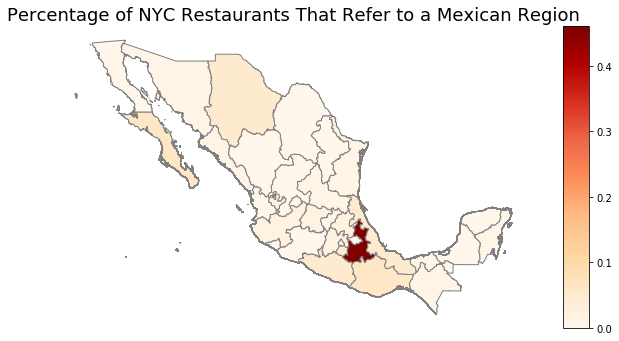

In [108]:
fig, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
mex_gdf_w_reg_pct.plot(column='NYC_pct', figsize=(10, 10), ax=ax, cmap = 'OrRd', edgecolor='grey',
                      legend=True, cax=cax)
ax.set_title("Percentage of NYC Restaurants That Refer to a Mexican Region", fontsize=18)
ax.axis('off')
plt.savefig("../my_saved_data/Map_of_NYC_regions.png", pad_inches='tight')

# Culinary Region Popularity for Each City

In [26]:
region_to_cul_reg_dict = turn_regions_to_cul_regions()

## Combine geometries in gdf

In [28]:
mex_gdf['Culinary_region'] = mex_gdf['Region'].replace(region_to_cul_reg_dict)

In [29]:
# combine all of the culinary regions with the geometries
cul_reg_geometry_dict = {key: [] for key in cul_reg_dict.keys()}

for idx, item in enumerate(mex_gdf['Culinary_region']):
    cul_reg_geometry_dict[item].append(mex_gdf['geometry'][idx])

In [30]:
# combining the polygons into one unit 
polygon_list = []
for key in cul_reg_geometry_dict.keys():
    polygon = []
    for idx, cul_region in enumerate(mex_gdf.Culinary_region):
        if key == cul_region:
            polygon.append(mex_gdf.geometry[idx])
    polygon_list.append(polygon)
combined_polygon_list = []
for x in polygon_list:
    boundary = gpd.GeoSeries(unary_union(x)) 
    combined_polygon_list.append(boundary)

In [31]:
# adding all of the data to a new (g)df
cul_regions = list(key for key in cul_reg_dict.keys())
cul_reg_df = pd.DataFrame(data = cul_regions,
                         columns = ['Culinary_region'])
cul_reg_df['geometry'] = [x.values[0] for x in combined_polygon_list]
cul_reg_gdf = gpd.GeoDataFrame(cul_reg_df, geometry = cul_reg_df.geometry)

In [32]:
cul_reg_gdf_w_pct1 = cul_reg_gdf.merge(city_w_cul_reg_pct, left_on = 'Culinary_region', right_on = 'Cul_reg',
                  how='outer')
cul_reg_gdf_w_pct = cul_reg_gdf_w_pct1.merge(cul_reg_for_all, left_on = 'Culinary_region', 
                                             right_on = 'Culinary_region', how='outer')

## Plot All Culinary Regions Together

In [33]:
# max_pct = int(cul_reg_gdf_w_pct.Percentage.max() * 100) + 1
# bin_range_max_pct = np.arange(1, max_pct, 10) / 100

In [34]:
# fig, ax = plt.subplots(1, figsize=(8,4))
# # fig.title('Percent of All Mexican Restaurants Referring to a Region From Four U.S. Cities', fontsize=20)
# ax.set_aspect('equal')
# cul_reg_gdf_w_pct.plot(color='white', edgecolor='black', ax=ax)

# cul_reg_gdf_w_pct.plot(column='Percentage', cmap = 'cividis', legend=True, 
#               scheme='User_Defined', ax=ax,
#               classification_kwds=dict(bins=bin_range_max_pct))
# ax.set_title("Distribution of Mexican Restaurants By Home Region in Mexico",fontsize=16)
# # ax.legend(['0', '0-10%', '10-20%', '20-30%'])
# ax.axis('off')

# # plt.savefig("./my_saved_data/Map_of_all_restaurants_and_their_regions.png", pad_inches='tight', orientation='landscape')

In [35]:
# EQUAL INTERVAL
percentiles_cul_reg = mc.Percentiles(cul_reg_gdf_w_pct['Percentage'], pct=[10])

In [36]:
# fig, ax = plt.subplots(1, figsize=(8,4))
# ax.set_aspect('equal')
# cul_reg_gdf_w_pct.plot(color='white', edgecolor='black', ax=ax)

# cul_reg_gdf_w_pct.plot(column='Percentage', cmap = 'cividis', legend=True, 
#               scheme='equal_interval', ax=ax)
# #               ,classification_kwds=dict(bins=percentiles_cul_reg))
# ax.set_title("Distribution of Mexican Restaurants By Mexican Culinary Region",fontsize=16)
# ax.axis('off')
# # plt.savefig("../my_saved_data/Map_of_all_restaurants_and_their_culinary_regions.png",
# #             pad_inches='tight', orientation='landscape')

In [37]:
# cul_reg_gdf_w_pct.plot(column='Percentage', scheme='EqualInterval', k=3, figsize=(16, 9),
#                       legend=True)

(-119.95182647705073,
 -85.12719879150391,
 13.623660850524958,
 33.627296638488765)

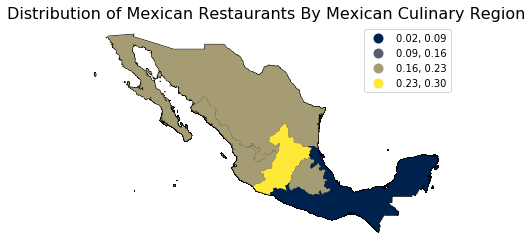

In [51]:
# DECILES
fig, ax = plt.subplots(1, figsize=(8,4))
ax.set_aspect('equal')
cul_reg_gdf_w_pct.plot(color='white', edgecolor='black', ax=ax)
cul_reg_gdf_w_pct.plot(column='Percentage', cmap = 'cividis', legend=True, 
              scheme='equal_interval', ax=ax, k=4)
#               ,classification_kwds=dict(bins=percentiles_cul_reg))
ax.set_title("Distribution of Mexican Restaurants By Mexican Culinary Region",fontsize=16)
ax.axis('off')

# # plt.savefig("../my_saved_data/Map_of_all_restaurants_and_their_culinary_regions2.png",
# #             pad_inches='tight', orientation='landscape')